In [1]:
# Main Libraries
import pandas as pd 
import numpy as np
from numpy import *

#Nice graphing tools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly
import plotly.offline as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls

import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import cophenet, fcluster
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics

PREPROCESSED_PATH = './../preprocessed/'
IMAGES_PATH = './../images/'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
# Reading groupped data
def read_groupped_data(filename):
    timeSeries = pd.read_csv(filename,index_col=['Unnamed: 0'], parse_dates=['Unnamed: 0'])
    timeSeries.rename(columns=lambda x: eval(x), inplace=True)
    timeSeries.index = pd.to_datetime(timeSeries.index)
    return timeSeries

# Plot dendrogram
def plot_dendrogram(Z, n_clusters):
    plt.figure(figsize=(40, 16))
    plt.title('Cluster Dendogram')
    plt.xlabel('Timeseries')
    plt.ylabel('Distance')
    hac.dendrogram(
        Z,
        truncate_mode='lastp',
        p=n_clusters,
        show_leaf_counts=True,
        show_contracted=True,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
    )
    plt.show()
    
def plot_silhouette(timeSeries, silhouette_avg, n_clusters, cluster_labels, pic_name=None):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 18)

    ax1.set_xlim([-0.1, 1])

    ax1.set_ylim([0, len(timeSeries) + (n_clusters + 3) * 10])
    y_lower = 10
    
    sample_silhouette_values = metrics.silhouette_samples(timeSeries, cluster_labels)
    silhouette_values = []
    
    for i in range(0, cluster_labels.max() + 1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        
        if ith_cluster_silhouette_values.shape[0] > 0:
            ith_cluster_silhouette_values.sort()
            silhouette_values.append(ith_cluster_silhouette_values)

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
        else:
            silhouette_values.append(pd.Series([]))

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1.0, -0.9,  -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    if pic_name:
        fig.savefig(IMAGES_PATH + pic_name + '.png')
    plt.suptitle(("Silhouette analysis for Time Series Clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    return pd.Series(silhouette_values)

In [3]:
# Reading time series data
timeSeries = read_groupped_data(PREPROCESSED_PATH + 'timeseries.csv')

In [4]:
# Removing time series without data
timeSeries = timeSeries.dropna(axis=1)

In [5]:
# Normalization between 0-1
normalization = MinMaxScaler()

# Z-score normalization
standardization = StandardScaler()

# Normalizing time series
timeSeriesNormalized = pd.DataFrame(normalization.fit_transform(timeSeries), index=timeSeries.index, columns=timeSeries.columns)
timeSeriesStandardized = pd.DataFrame(standardization.fit_transform(timeSeries), index=timeSeries.index, columns=timeSeries.columns)

In [6]:
X_normalized = timeSeriesNormalized.T
X_standardized = timeSeriesStandardized.T

# Applying ward method for clustering
Z_normalized = hac.linkage(X_normalized, method='ward')
Z_standardized = hac.linkage(X_standardized, method='ward')

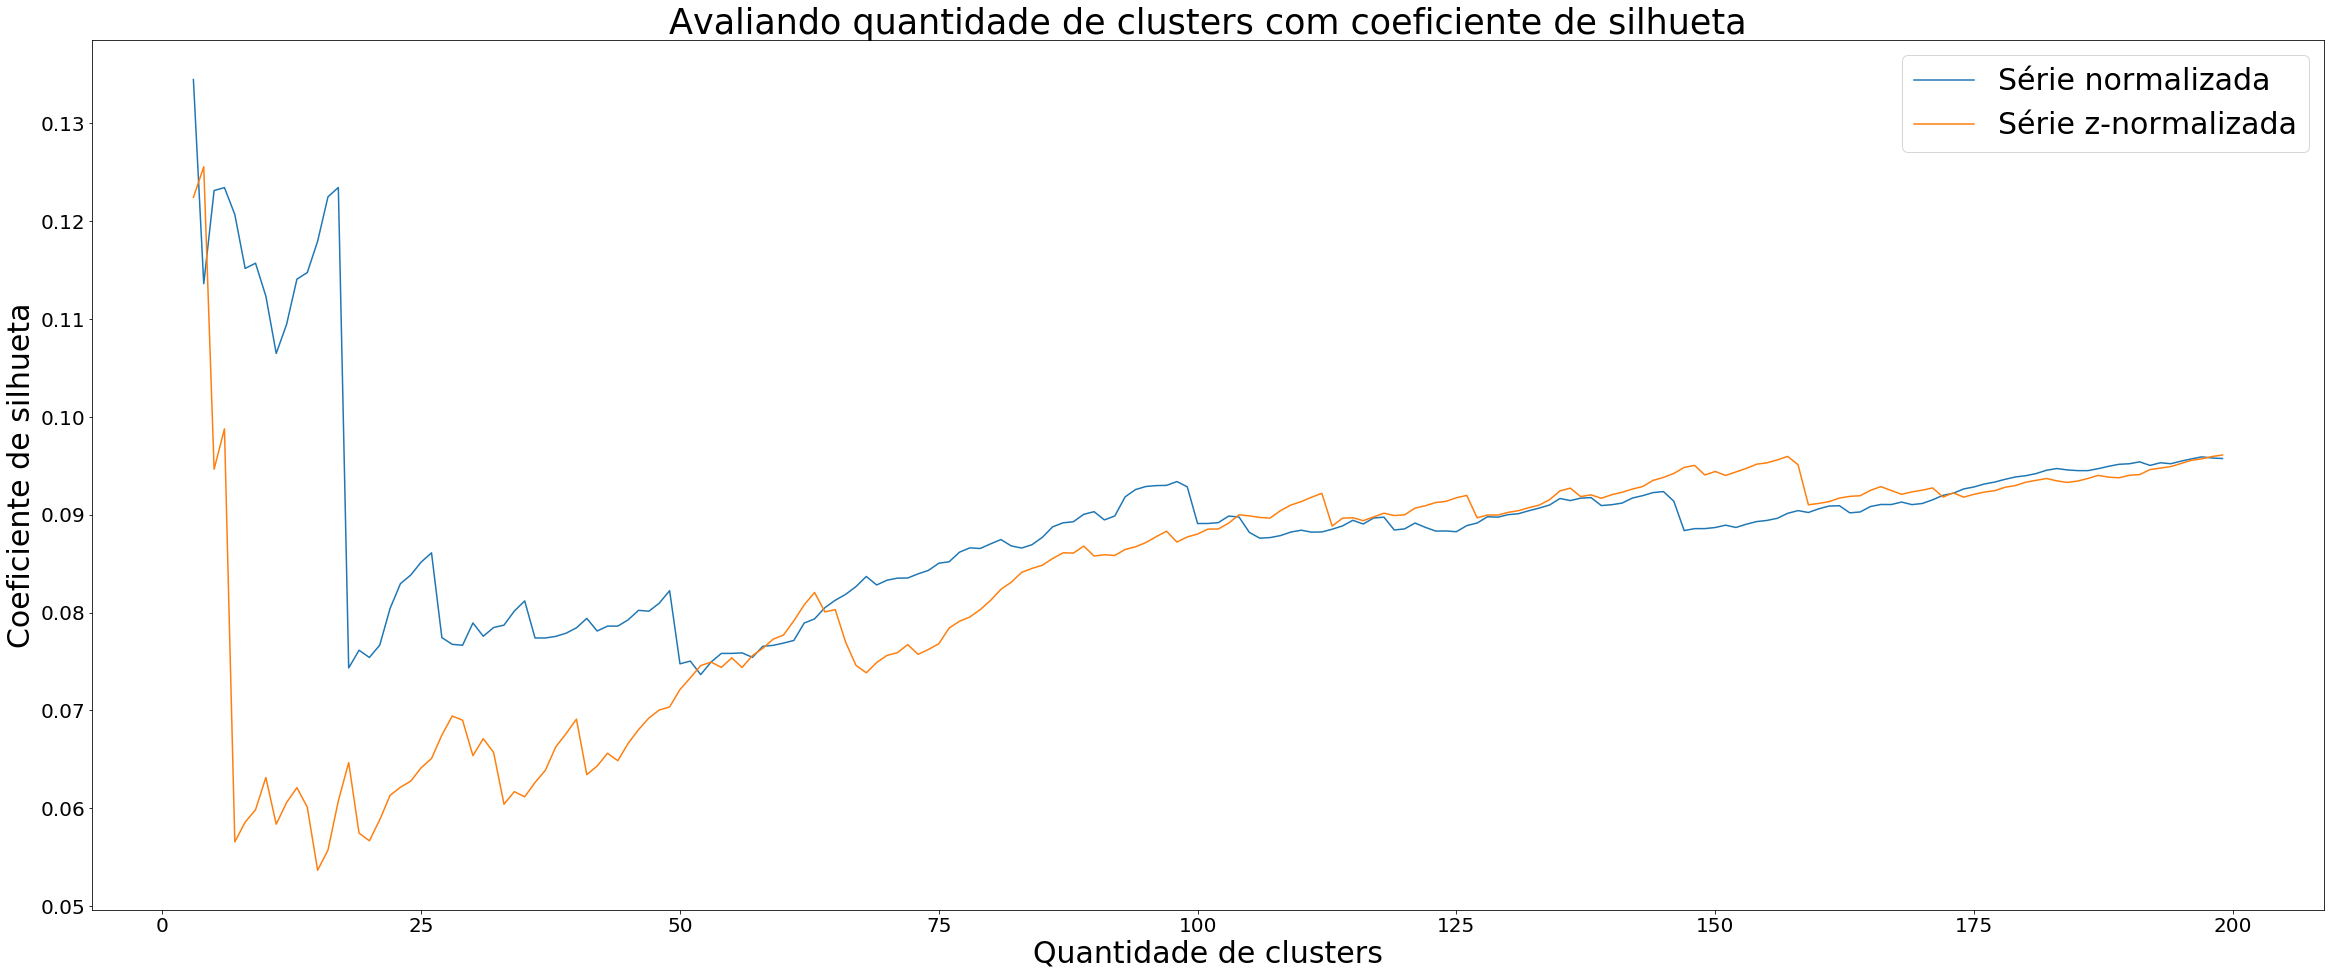

In [40]:
TEST_SILHOUETTE_AVG = True
        
if TEST_SILHOUETTE_AVG:
    normalized_avg = pd.DataFrame(columns=['n_clusters', 'avg'])
    standardized_avg = pd.DataFrame(columns=['n_clusters', 'avg'])
    for i in range(3, 200):
        cluster_labels = fcluster(Z_normalized, i, criterion="maxclust")
        avg = metrics.silhouette_score(X_normalized, cluster_labels, metric='euclidean')
        normalized_avg = normalized_avg.append(pd.DataFrame([[i, avg]], columns=['n_clusters', 'avg']), ignore_index=True)
        
        cluster_labels = fcluster(Z_standardized, i, criterion="maxclust")
        avg = metrics.silhouette_score(X_standardized, cluster_labels, metric='euclidean')
        standardized_avg = standardized_avg.append(pd.DataFrame([[i, avg]], columns=['n_clusters', 'avg']), ignore_index=True)
    
    plt.figure(figsize=(40,16,))
    plt.title('Avaliando quantidade de clusters com coeficiente de silhueta', fontsize=35)
    plt.xlabel('Quantidade de clusters', fontsize=30)
    plt.ylabel('Coeficiente de silhueta', fontsize=30)
    plt.plot(normalized_avg.set_index('n_clusters'), label='Série normalizada')
    plt.plot(standardized_avg.set_index('n_clusters'), label='Série z-normalizada')
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(loc='best', prop={'size': 30})